In [1]:
1+1

2

In [6]:
import numpy as np
import pylab as plt
import h5py
from pynx.wavefront import *
from pynx.ptycho.analysis import modes

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Functions

In [12]:
def WavelengthAndPixelSize(file):
    wavelength = file['entry_last/instrument_1/beam_1/incident_wavelength'][()]
    x_pixel_size = file['entry_last/probe/x_pixel_size'][()]
    y_pixel_size = file['entry_last/probe/y_pixel_size'][()]


    print('wavelength :',wavelength*1e10, 'Angstrom')
    print('pixel size :',x_pixel_size*1e9, 'nm')

    if x_pixel_size != y_pixel_size:
        print('pixel size different between vertical and horizontal !')
    return wavelength, x_pixel_size, y_pixel_size

def ProbeDataPixel(cxi_file, plot=False):
    
    file = h5py.File(cxi_file, 'r')
    
    wavelength = file['entry_last/instrument_1/beam_1/incident_wavelength'][()]
    x_pixel_size = file['entry_last/probe/x_pixel_size'][()]
    y_pixel_size = file['entry_last/probe/y_pixel_size'][()]
    
    probe = file['entry_last/probe/data'].__array__()
    probe, mode_int = modes(probe, x_pixel_size, do_plot=False, show_plot=False, verbose=False)
    
    if plot:
         PlotProbe(probe, x_pixel_size, y_pixel_size, mode_int)
    
    return probe, wavelength, x_pixel_size, y_pixel_size

def PlotProbe(probe, x_pixel_size, y_pixel_size, mode_int):
    pixel_x = np.arange(probe[0].shape[1])*x_pixel_size*1e6 # in micrometers
    pixel_x -= np.max(pixel_x)/2.
    pixel_y = np.arange(probe[0].shape[0])*y_pixel_size*1e6 # in micrometers
    pixel_y -= np.max(pixel_y)/2.
    
    # Plot the modes
    n_col = 6
    n_row = int(np.ceil(len(probe)/n_col))
    fig,ax = plt.subplots(n_row ,n_col,figsize=(4*n_col,4*n_row))
    axe = ax.flatten()
    for n in range(len(axe)):
        if n<len(probe):
            im = axe[n].imshow(np.abs(probe[n]),extent=(min(pixel_x), max(pixel_x), min(pixel_y), max(pixel_y)))
            divider = make_axes_locatable(axe[n])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')    

            axe[n].set_title('mode {}\nintensity {} %'.format(n,round(100*mode_int[n],2)), fontsize=20)
            axe[n].set_xlabel(r'x ($\mu$m)', fontsize=15)
            axe[n].set_ylabel(r'y ($\mu$m)', fontsize=15)
        else:
            fig.delaxes(axe[n])
    fig.tight_layout()
        
    return

In [2]:
def PropagateProbe(probe,
                   propagation_distance, # in meters
                   array_final_size, # in micrometers
                   wavelength, pixel_size,
                   plot=False):
    size = int(np.ceil(array_final_size/(pixel_size*1e6)))
    print('array final size : {} x {} pixels'.format(size,size))
    
    X = np.arange(-size//2, size//2)*pixel_size
    Y = np.arange(-size//2, size//2)*pixel_size
    X,Y = np.meshgrid(X,Y)

    k = 2.*np.pi/wavelength
    g = np.exp(1.0j*k*(X**2. + Y**2.) / (2.*propagation_distance)  )
    
    probe_propa = signal.fftconvolve(g,probe, mode='same')
    
    if plot:
        size = 1e6*pixel_size*len(probe_propa)/2.
        plt.figure()
        plt.imshow(np.abs(probe_propa), extent=[-size,size, -size,size])
        plt.xlabel('x ($\mu$m)', fontsize=15)
        plt.ylabel('y ($\mu$m)', fontsize=15)
    
    return probe_propa

In [3]:
def computePropagationAroundObjectPosition(probe, 
                                           Nb_propa = 100, 
                                           propa_step = 10e-6,
                                           plot=False):
    # Propagation toward the source
    w = Wavefront(d=probe, pixel_size=x_pixel_size, wavelength=wavelength)
    probe_propa_negative = np.zeros((Nb_propa,)+probe.shape, dtype='complex64')
    for n in range(Nb_propa):
        w = PropagateNearField(-propa_step) * w
        probe_propa_negative[n] += w.get()[0]

    # Propagation away from the source
    w = Wavefront(d=probe, pixel_size=x_pixel_size, wavelength=wavelength)
    probe_propa_positive = np.zeros((Nb_propa,)+probe.shape, dtype='complex64')
    for n in range(Nb_propa):
        w = PropagateNearField(propa_step) * w
        probe_propa_positive[n] += w.get()[0]

    # Merge these propagations
    probe_propa = np.zeros((2*Nb_propa+1,)+probe.shape, dtype='complex64')
    probe_propa[:Nb_propa] += probe_propa_negative[::-1]
    probe_propa[Nb_propa] += probe
    probe_propa[Nb_propa+1:] += probe_propa_positive

    propa_dist = np.arange(-Nb_propa, Nb_propa+1)*propa_step
    
    if plot:
        PlotPropagationProfile(probe_propa, propa_dist)
    
    return probe_propa, propa_dist

def PlotPropagationProfile(probe_propa, propa_dist):
    plt.figure(101, figsize=(12,4))
    plt.matshow(np.swapaxes(np.sum(np.abs(probe_propa),axis=2),0,1), aspect=.02*Nb_propa/10, fignum=101, cmap='gray_r')
    plt.axvline(x=Nb_propa+1,color='r', linestyle='--')
    plt.text(Nb_propa+1, probe.shape[1]*.9,'object position', color='r', fontsize=15)
    return

In [4]:
def get_focal_using_maximum_projection(probe_propa, propa_dist,
                                       plot=False):
    
    profile = np.sum(np.abs(probe_propa),axis=2)
    profile_max = np.max(profile,axis=1)
    index_max = np.argmax(profile_max)
    
    probe_focal = probe_propa[index_max]
    
    if plot:
        plt.figure()
        plt.plot(propa_dist*1e6, profile_max, 'b')
        plt.axvline(x=propa_dist[index_max]*1e6, color='b', linestyle='--', label='maximum position')
        plt.legend(fontsize=12)
        
        PlotPropagationProfile(probe_propa, propa_dist)
        plt.axvline(x=index_max,color='b', linestyle='--')
        plt.text(index_max, probe.shape[1]*.1,'found focal plane', color='b', fontsize=15)
        plt.title('Check that the found focal is correct', fontsize=20)
        
        fig,ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].matshow(np.abs(probe_propa[int(round(probe_propa.shape[0]/2))]))
        ax[1].matshow(np.abs(probe_focal))
        ax[0].set_title('pynx reconstructed probe\nat object position', fontsize=15)
        ax[1].set_title('propagated probe at the focal', fontsize=15)
        fig.tight_layout()
        
    return probe_focal

# Data treatment

In [13]:
cxi_file = '/data/id01/inhouse/bellec/local_contact/2022/HC4755_Kim/Saved_ptycho_scan/beam_recon/ResultsScan0009/Run0001.cxi'

probe, wavelength, x_pixel_size, y_pixel_size = ProbeDataPixel(cxi_file, plot=True)

# Only take the first mode
probe = probe[0]

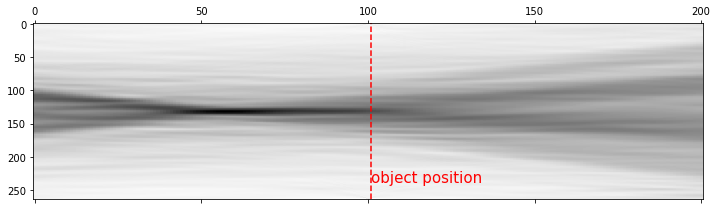

In [14]:
Nb_propa = 100
propa_step = 10e-6

probe_propa, propa_dist = computePropagationAroundObjectPosition(probe, 
                                           Nb_propa = Nb_propa, 
                                           propa_step = propa_step,
                                            plot=True)
# Make sure that the focal is somewhere in the plot below. 
# Otherwise, change propa_step and/or Nb_propa

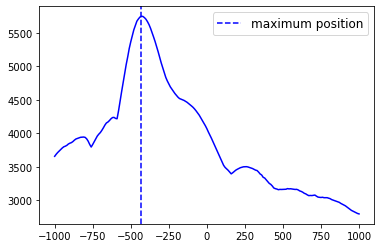

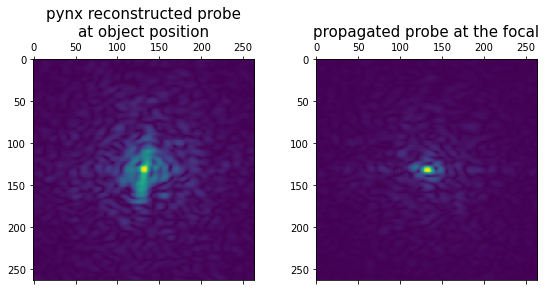

In [15]:
probe_focal = get_focal_using_maximum_projection(probe_propa, propa_dist,
                                       plot=True)

In [17]:
savename = '{}_probe_at_focal'.format(cxi_file[:-4]) # Change that if needed
print('saving at : {}.npz'.format(savename))

np.savez(savename, probe_focal=probe_focal, wavelength=wavelength, x_pixel_size=x_pixel_size, y_pixel_size=y_pixel_size)

saving at : /data/id01/inhouse/bellec/local_contact/2022/HC4755_Kim/Saved_ptycho_scan/beam_recon/ResultsScan0009/Run0001_probe_at_focal.npz
